<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/pantompskin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [ ]:
! pip install wfdb
! pip install scipy

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

## Imports 

In [ ]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
import sys

# sys.path.append( '../../src' )
import readin
import display
# import pantompkins

## Run Method

In [ ]:
def run_pantompkins(path, lead, low_cutoff, high_cutoff, sampling_freq, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= readin.get_data(example_path, leads, 0, signal_length)
    raw_samples = raw_samples.squeeze()
    samples =raw_samples - np.mean(raw_samples)

    low_pass = algorithms.pantompkins.lowpass_filter(samples, high_cutoff, sampling_freq)
    high_pass = algorithms.pantompkins.highpass_filter(low_pass, low_cutoff, sampling_freq)

    derived = algorithms.pantompkins.derivative(high_pass, sampling_freq)
    squared = algorithms.pantompkins.squaring(derived)

    mvg = algorithms.pantompkins.moving_window_integration(squared, int(0.15*sampling_freq))

    peaks = algorithms.pantompkins.pan_tompkins(samples, sampling_freq, low_cutoff, high_cutoff)
    fig, axs = plt.subplots(8, figsize=(15, 40))
    axs[0].plot(raw_samples)
    axs[0].title.set_text('a) Raw')
    axs[1].plot(samples)
    axs[1].title.set_text('b) Shifted')
    axs[2].plot(high_pass)
    axs[2].title.set_text('c) Bandpass')
    axs[3].plot(derived)
    axs[3].title.set_text('d) Derivative')
    axs[4].plot(squared)
    axs[4].title.set_text('e) Squaring')
    axs[5].plot(mvg)
    axs[5].title.set_text('f) Moving Average')
    display.np_mark_peaks(axs[6], samples, peaks, 'g) Peaks')
    display.np_mark_peaks(axs[7], samples, real_peaks, 'h) Annotations')

    return peaks, real_peaks

def evaluation(peaks, real_peaks, interval):
    check_peaks = real_peaks[1:]
    n_ref = len(check_peaks)
    n_detected = len(peaks)
    count = 0
    checked_ind = 0
    for i in range(n_detected):
      det_peak = peaks[i]
      for j in range(checked_ind, n_ref):
          correct = check_peaks[j]
          if det_peak > correct -interval and det_peak < correct +interval:
              count +=1
              checked_ind += 1
              break

    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": str(sensitivity*100)+'%',
              'PPV': str(ppv*100)+'%',
              'F1': str(f1*100) + '%'
              }
    return result

In [ ]:
def test_pantompkins(path, lead, low_cutoff, high_cutoff, sampling_freq, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= readin.get_data(example_path, leads, 0, signal_length)
    raw_samples = raw_samples.squeeze()
    samples =raw_samples - np.mean(raw_samples)

    peaks = pantompkins.pan_tompkins(samples, sampling_freq, low_cutoff, high_cutoff)

    return peaks, real_peaks

## Tests

Clean Signal


{'sensitivity': '100.0%', 'PPV': '92.5%', 'F1': '96.1038961038961%'}

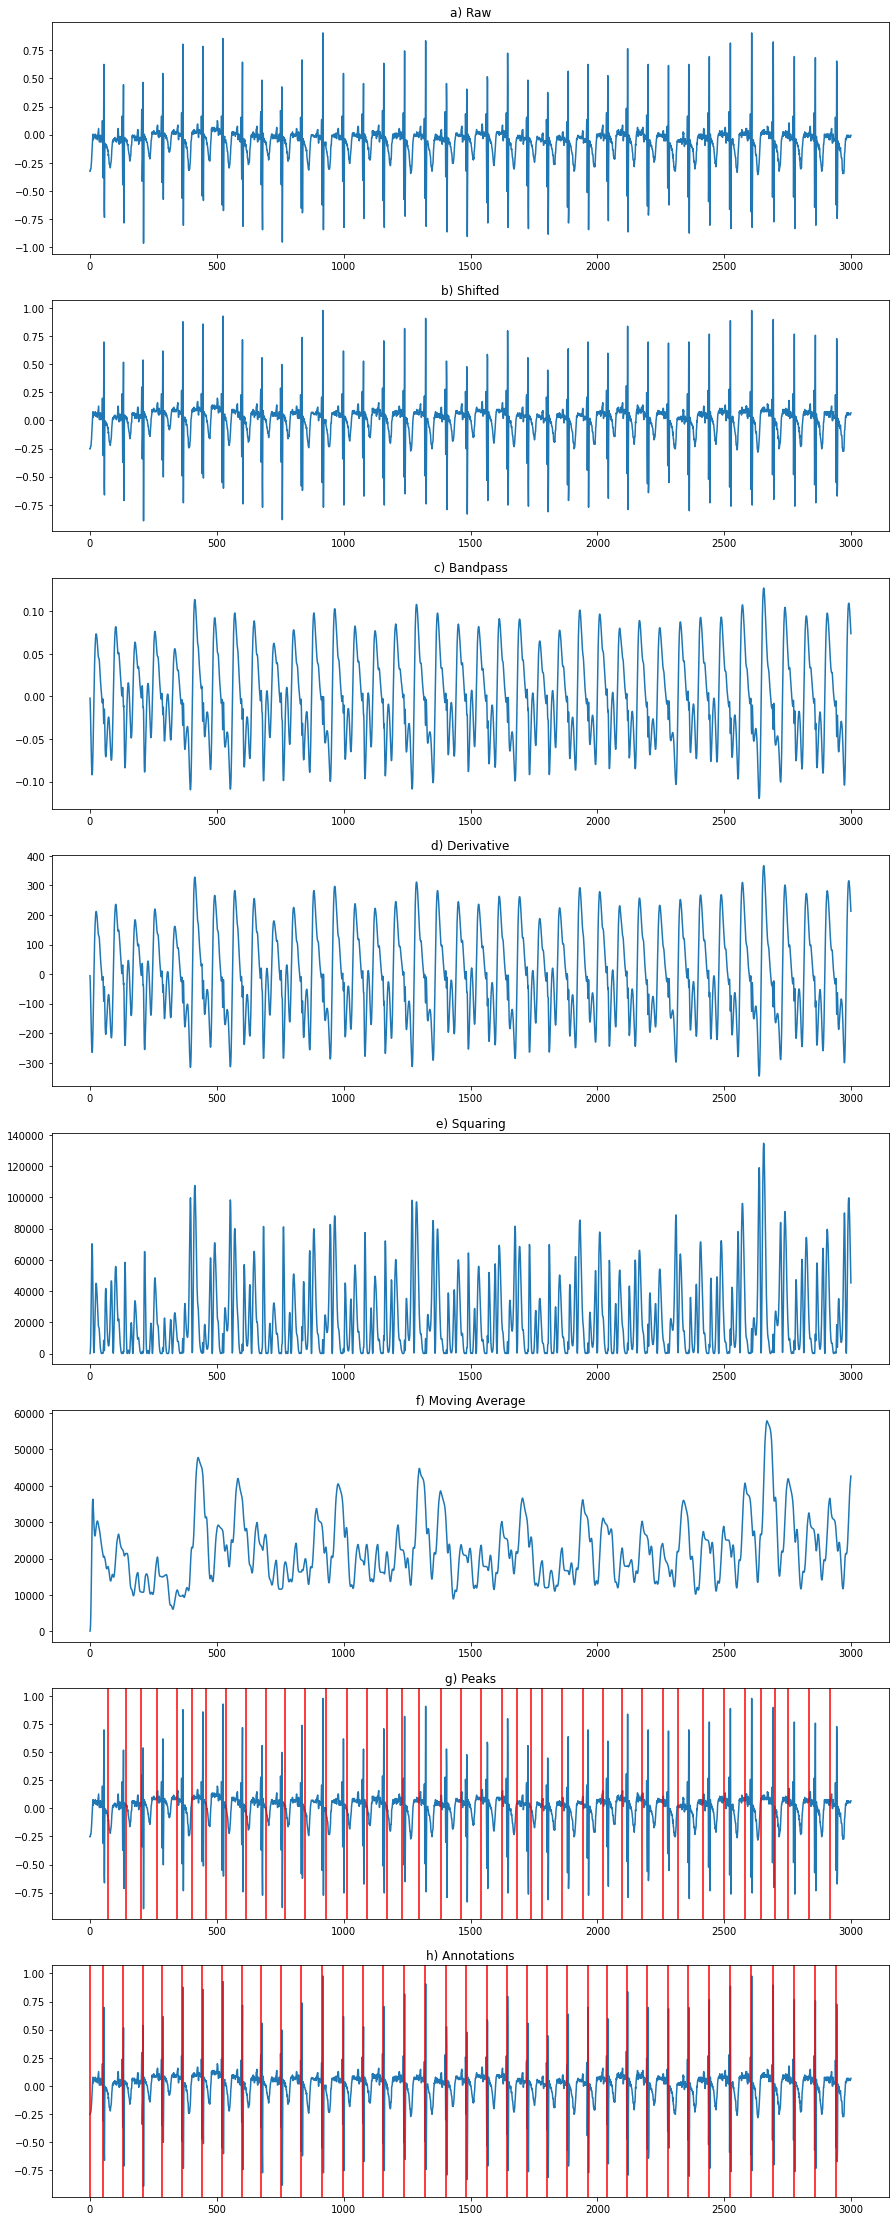

In [ ]:
print('Clean Signal')
peaks, real_peaks = run_pantompkins('/content/physionet.org/files/nsrdb/1.0.0/16265', 'ECG2', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

In [ ]:
print('6db noise Signal')
peaks, real_peaks = run_pantompkins('../../datasets/nstdb/118e06', 'V1', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

In [ ]:
print('12db noise Signal')
peaks, real_peaks = run_pantompkins('../../datasets/nstdb/118e12', 'MLII', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

In [ ]:
print('24db noise Signal')
peaks, real_peaks = run_pantompkins('../../datasets/nstdb/118e24', 'V1', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

In [ ]:
print('24db noise Signal')
peaks, real_peaks = run_pantompkins('../../datasets/nstdb/118e24', 'V1', 0.6, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

## AF Dataset

In [ ]:
annots = wfdb.rdann('../../datasets/mit-af/07162', 'atr', sampfrom=0, sampto=1000)
annots.sample

In [ ]:
print('AF Signal')
peaks, real_peaks = run_pantompkins('....//datasets/mit-af/07162', 'ECG2', 5, 128, 1000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

## Run on Whole Dataset

In [ ]:
import os
import glob

In [ ]:
arr = os.listdir('/content/physionet.org/files/nsrdb/1.0.0')

sample_ids = []
for file in arr:
    if '.atr' in file:
        sample_ids.append(file[:5])
        

In [ ]:
root_folder = '/content/physionet.org/files/nsrdb/1.0.0/'
sensitivity = []
ppv = []
f1 = []


## Neurokit 2 Implementation Test

In [ ]:
! pip install neurokit2

In [ ]:
import neurokit2 as nk2

In [ ]:
def test_nk2_pt(path, lead, low_cutoff, high_cutoff, sampling_freq, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= readin.get_data(example_path, leads, 0, signal_length)
    raw_samples = raw_samples.squeeze()
    # samples =raw_samples - np.mean(raw_samples)
    cleaned = nk2.ecg_clean(raw_samples, sampling_freq, method='pantompkins1985')
    signals, info = nk2.ecg_peaks(cleaned, sampling_freq, method='pantompkins1985')

    return info["ECG_R_Peaks"], real_peaks

In [ ]:
root_folder = '/content/physionet.org/files/nsrdb/1.0.0/'
sensitivity = []
ppv = []
f1 = []

In [ ]:
for id in sample_ids:
    sample_path = root_folder + id
    peaks, real_peaks = test_nk2_pt(sample_path, 'ECG2', 5, 11, 128, 60*60*128*8)
    print('hi')
    res = evaluation(peaks, real_peaks, int(150/(1000/128)))
    sensitivity.append(res['sensitivity'])
    ppv.append(res['PPV'])
    f1.append(res['F1'])
    print(res)

hi
{'sensitivity': '99.53823465415952%', 'PPV': '99.95630007283322%', 'F1': '99.74682930965561%'}
hi
{'sensitivity': '99.85972932955815%', 'PPV': '99.97139439330108%', 'F1': '99.91553066236956%'}
hi
{'sensitivity': '99.08212754018197%', 'PPV': '99.9878655502973%', 'F1': '99.53293606055726%'}
hi
{'sensitivity': '99.41262848751835%', 'PPV': '99.94761405848176%', 'F1': '99.67940345294355%'}
hi
{'sensitivity': '94.14900589906053%', 'PPV': '99.96520286728374%', 'F1': '96.96996973345186%'}
hi
{'sensitivity': '99.11885292318844%', 'PPV': '99.77199142687765%', 'F1': '99.44434975285495%'}
hi
{'sensitivity': '99.7729613332085%', 'PPV': '99.99530835815995%', 'F1': '99.88401110681522%'}
hi
{'sensitivity': '98.29369341721652%', 'PPV': '99.98439158394206%', 'F1': '99.13183429022425%'}
hi
{'sensitivity': '99.58975917344071%', 'PPV': '99.99745728234338%', 'F1': '99.79319182409886%'}
hi
{'sensitivity': '99.41496709189892%', 'PPV': '99.9727631758137%', 'F1': '99.69308490412297%'}
hi
{'sensitivity': '99.

In [ ]:
def to_float(arr):
    ret = []
    for x in arr:
        ret.append(float(x[0:-1]))
    return ret 

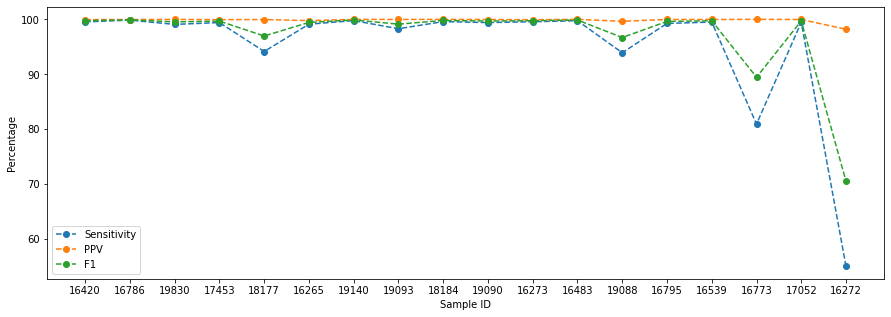

In [ ]:
plt.figure(figsize=(15,5))
plt.xlabel('Sample ID')
plt.ylabel('Percentage')

plt.plot(sample_ids, to_float(sensitivity), label='Sensitivity', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(ppv), label='PPV', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(f1), label='F1', marker='o', linestyle='--')

plt.legend()

In [ ]:
np.average(to_float(sensitivity)), np.average(to_float(ppv)), np.average(to_float(f1))

(95.31572599765028, 99.84728084963241, 97.17770124099373)

In [ ]:
np.average(to_float(sensitivity)), np.average(to_float(ppv)), np.average(to_float(f1))

(95.3157259976503, 99.84728084963241, 97.17770124099373)

In [ ]:
ecg2_sen, ecg2_ppv, ecg2_f1= to_float(sensitivity), to_float(ppv), to_float(f1)